We will use simple economic model of Churn:
- You have historical data about customers who churn and not churn.
- You have a predictive model which for every customer predict whether he will churn or not churn next month.
- You know if you give a discount d% to a churn customer, he will not churn.
- Telecom company do not have any accompanying expenses on any discount strategy. 
- Baseline ("0 profit") solution corresponds to the case where we do not apply any discount strategy and loose all churned clients

In [1]:
import pandas as pd

In [3]:
df_train = pd.read_csv('./train.csv')
df_test = pd.read_csv('./test.csv')

In [3]:
df_train.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,3472-OAOOR,Male,0,Yes,Yes,19,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,34.95,610.2,No
1,5393-RXQSZ,Male,0,No,No,1,Yes,No,Fiber optic,No,...,No,No,No,Yes,Month-to-month,No,Electronic check,79.60,79.6,Yes
2,0968-GSIKN,Female,0,No,No,1,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,70.80,70.8,Yes
3,1057-FOGLZ,Female,0,No,No,18,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,19.65,391.7,No
4,3244-CQPHU,Female,1,No,No,72,Yes,Yes,Fiber optic,Yes,...,No,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),110.10,7746.7,No


### 1. What is the percentage of MonthlyCharges payed by customers who will Churn? Single integer number 0..100. 

In [4]:
round(100 * df_train.query('Churn=="Yes"').MonthlyCharges.sum() / df_train.MonthlyCharges.sum())

30

### 2. Compute the profit of 20% discount (MonthlyCharges based) on a test set in scenario where you have "perfect", 100% accurate classification model. How much money company saves, assuming all customers accepts it and do not churn? Single float number, with 2 significant digits, e.g. 10.16 .

In [4]:
# Do nothing strategy

baseline = df_test.query('Churn=="No"').MonthlyCharges.sum()

# 20% to all Churn==Yes

churn_profit = df_test.query('Churn=="Yes"').MonthlyCharges.sum() * (1-0.2)
print(churn_profit)
# Total = baseline + churn_profit

45331.72000000001


### 3. Build any binary classification model, which output probabilities (e.g. Logistic Regression, Gradient Boosting, etc.) using training set. Make predictions on a test set. Upload a csv file with your predictions (it should contain 2 columns, customerID and PredictedYes). For all remaining computations you must use these predictions.

In [6]:
cat_features = list(df_train.dtypes.sort_values().iloc[4:-1].index)

In [7]:
from sklearn.model_selection import train_test_split

X = df_train.drop(['customerID', 'Churn'], axis=1)
y = df_train['Churn']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=101)

In [8]:
from catboost import CatBoostClassifier, Pool

In [9]:
dataset_train = Pool(X_train, y_train, cat_features)
dataset_val = Pool(X_val, y_val, cat_features)

In [10]:
model = CatBoostClassifier()

model.fit(dataset_train, eval_set=dataset_val,
          verbose=50)

Learning rate set to 0.04142
0:	learn: 0.6695746	test: 0.6693604	best: 0.6693604 (0)	total: 55ms	remaining: 54.9s
50:	learn: 0.4134554	test: 0.4269068	best: 0.4269068 (50)	total: 279ms	remaining: 5.19s
100:	learn: 0.3903401	test: 0.4161160	best: 0.4161160 (100)	total: 494ms	remaining: 4.4s
150:	learn: 0.3783729	test: 0.4133344	best: 0.4133344 (150)	total: 707ms	remaining: 3.97s
200:	learn: 0.3669750	test: 0.4123317	best: 0.4120338 (196)	total: 911ms	remaining: 3.62s
250:	learn: 0.3527352	test: 0.4108793	best: 0.4108257 (249)	total: 1.13s	remaining: 3.38s
300:	learn: 0.3420362	test: 0.4108417	best: 0.4103664 (286)	total: 1.36s	remaining: 3.17s
350:	learn: 0.3303216	test: 0.4120628	best: 0.4103664 (286)	total: 1.58s	remaining: 2.91s
400:	learn: 0.3196213	test: 0.4131968	best: 0.4103664 (286)	total: 1.79s	remaining: 2.68s
450:	learn: 0.3115798	test: 0.4137516	best: 0.4103664 (286)	total: 2.02s	remaining: 2.46s
500:	learn: 0.3030296	test: 0.4149258	best: 0.4103664 (286)	total: 2.24s	remain

In [11]:
df_test = pd.read_csv('./test.csv')

In [12]:
X_test = df_test.drop(['customerID', 'Churn'], axis=1)
y_test = df_test['Churn']

dataset_test = Pool(X_test, y_test, cat_features)

In [13]:
y_pred_test_proba = model.predict_proba(dataset_test)
y_pred_test = model.predict(dataset_test)

In [14]:
y_pred_test

array(['No', 'No', 'No', ..., 'No', 'No', 'No'], dtype=object)

In [15]:
df_test_pred = pd.DataFrame()
df_test_pred['customerID'] = df_test['customerID']
df_test_pred['PredictedYes'] = y_pred_test_proba[:, 1]
df_test_pred.to_csv('./predictions.csv', index=False)

In [16]:
df_test_pred.head(5)

,customerID,PredictedYes
0,8659-IOOPU,0.134771
1,0887-HJGAR,0.498764
2,1029-QFBEN,0.247074
3,7579-OOPEC,0.379066
4,8473-VUVJN,0.866570


### 4. What is ROC AUC of your model on a test set? Single integer number 0..100. 

In [17]:
from sklearn.metrics import roc_auc_score

In [18]:
round(100*roc_auc_score(y_test.map({'Yes':1, 'No':0}).values, y_pred_test_proba[:, 1]))

85

###  5. What are TP, FP, TN, FN for probability threshold 0.5 (4 integer numbers divided by a comma, e.g. 10,20,15,5). You can use example from <> spreadsheet to compute the confusion matrix.

In [19]:
from sklearn.metrics import confusion_matrix

In [20]:
tn, fp, fn, tp = confusion_matrix(y_test.map({'Yes':1, 'No':0}).values, 
                                  y_pred_test_proba[:, 1]>=0.5).ravel()

In [21]:
tn, fp, fn, tp

(1854, 205, 337, 422)

tp = Those who will Churn and we predict them as Churn
tn = Those who will not Churn and we predict them as not Churn
fp = Those who will not Churn, but we predict that they will Churn
fn = Those who will Churn, but we predict that they will not

### 6. Compute the profit of 20% discount (MonthlyCharges based), assuming you give it to all customers predicted as Churned (TP and FP). Single float number, with 2 significant digits, e.g. 10.16 .

In [22]:
df_test['PredictedYes'] = y_pred_test_proba[:, 1]>=0.5
df_test['PredictedYes'] = df_test['PredictedYes'].map({True:'Yes', False:'No'})

In [23]:
# Do nothing strategy

baseline = df_test.query('Churn=="No"').MonthlyCharges.sum()

# 20% to all PredictedYes==Yes

profit_tp = df_test.query('Churn=="Yes"').query('PredictedYes=="Yes"').MonthlyCharges.sum() * (1-0.2)
profit_tn = df_test.query('Churn=="No"').query('PredictedYes=="No"').MonthlyCharges.sum()
profit_fp = df_test.query('Churn=="No"').query('PredictedYes=="Yes"').MonthlyCharges.sum() * (1-0.2)
# profit_fn = 0 as we loose them anyway, or we could interpret them as money loss, as we give them
# a discount current month and they left next month, both solutions will be considered as correct
profit_fn = df_test.query('Churn=="Yes"').query('PredictedYes=="No"').MonthlyCharges.sum() * (-0.2)

total_1 = profit_tp + profit_tn + profit_fp 
total_2 = total_1 + profit_fn

In [24]:
print(baseline, total_1, total_2)

126669.1 150130.63 145495.88


In [25]:
print(total_1 - baseline, total_2 - baseline)

23461.53 18826.78


### 7. What if we only give discount (20%) to top p% of customers (p% of customers with the highest probability to churn, predicted by our model). Find p, which maximizes the profit. Recall that p might not coincide with probability threshold outputed by your classifier (e.g. using threshold of 0.65 you end up with 50% of the customers). Single integer number 0..100. 

In [26]:
def get_profit(y_pred_proba, baseline, percent):
    
    df_test['PredictedYes'] = y_pred_test_proba[:, 1]
    n = df_test.shape[0]
    index = round(n / 100 * percent)
    index_yes = df_test.sort_values(by='PredictedYes', ascending=False).iloc[:index]['PredictedYes'].index
    index_no = df_test.sort_values(by='PredictedYes', ascending=False).iloc[index:]['PredictedYes'].index

    df_test.at[index_yes, 'PredictedYes'] =  'Yes'
    df_test.at[index_no, 'PredictedYes'] =  'No'
    
    profit_tp = df_test.query('Churn=="Yes"').query('PredictedYes=="Yes"').MonthlyCharges.sum() * (1-0.2)
    profit_tn = df_test.query('Churn=="No"').query('PredictedYes=="No"').MonthlyCharges.sum()
    profit_fp = df_test.query('Churn=="No"').query('PredictedYes=="Yes"').MonthlyCharges.sum() * (1-0.2)
    profit_fn = df_test.query('Churn=="Yes"').query('PredictedYes=="No"').MonthlyCharges.sum() * (-0.2)
    
    total_1 = profit_tp + profit_tn + profit_fp 
    total_2 = total_1 + profit_fn
    
    return total_1 - baseline, total_2 - baseline

In [27]:
total_profit = []

for percent in range(1,100):
    total_1, _ = get_profit(y_pred_test_proba, baseline, percent)
    total_profit.append(total_1)

In [28]:
import matplotlib.pyplot as plt
import numpy as np

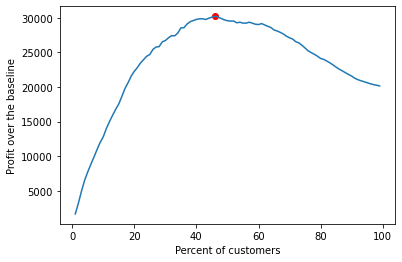

In [29]:
plt.plot(range(1,100), total_profit);
max_p = np.argmax(total_profit)
plt.scatter(list(range(1,100))[max_p], total_profit[max_p], c='r')
plt.xlabel('Percent of customers')
plt.ylabel('Profit over the baseline');

In [30]:
max_p

45

### 8. Instead of 20% discount we now give constant 10$ discount. How your answer to the previous question changes? Single integer number 0..100. 

In [31]:
def get_profit(y_pred_proba, baseline, percent):
    
    df_test['PredictedYes'] = y_pred_test_proba[:, 1]
    n = df_test.shape[0]
    index = round(n / 100 * percent)
    index_yes = df_test.sort_values(by='PredictedYes', ascending=False).iloc[:index]['PredictedYes'].index
    index_no = df_test.sort_values(by='PredictedYes', ascending=False).iloc[index:]['PredictedYes'].index

    df_test.at[index_yes, 'PredictedYes'] =  'Yes'
    df_test.at[index_no, 'PredictedYes'] =  'No'
    
    profit_tp = df_test.query('Churn=="Yes"').query('PredictedYes=="Yes"').MonthlyCharges.sum() -\
                df_test.query('Churn=="Yes"').query('PredictedYes=="Yes"').shape[0] * 10
    
    profit_tn = df_test.query('Churn=="No"').query('PredictedYes=="No"').MonthlyCharges.sum()
    profit_fp = df_test.query('Churn=="No"').query('PredictedYes=="Yes"').MonthlyCharges.sum() -\
                df_test.query('Churn=="No"').query('PredictedYes=="Yes"').shape[0] * 10
    
    profit_fn = -df_test.query('Churn=="Yes"').query('PredictedYes=="No"').shape[0]*10
                
    total_1 = profit_tp + profit_tn + profit_fp 
    total_2 = total_1 + profit_fn
    
    return total_1 - baseline, total_2 - baseline

In [32]:
total_profit = []

for percent in range(1,100):
    total_1, _ = get_profit(y_pred_test_proba, baseline, percent)
    total_profit.append(total_1)

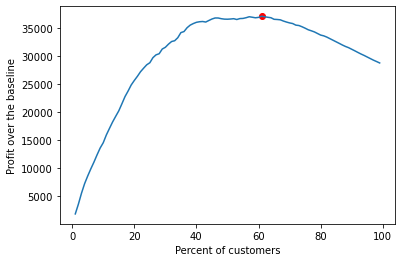

In [33]:
plt.plot(range(1,100), total_profit);
max_p = np.argmax(total_profit)
plt.scatter(list(range(1,100))[max_p], total_profit[max_p], c='r')
plt.xlabel('Percent of customers')
plt.ylabel('Profit over the baseline');

In [34]:
max_p

60